In [1]:
print('what\'s up')

what's up


In [2]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
EXAMPLE_FILE = 'SpamData/01_processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_processing/word_by_id.csv'
TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'


WHALE_FILE = 'SpamData/01_processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_processing/wordcloud_resources/thumbs-down.png'
FONT = 'SpamData/01_processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body=False
lines=[]

for line in stream:
    if is_body:
        lines.append(line)
    elif line =='\n':
        is_body = True
stream.close()

email_body = '\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [7]:
def generator_function(N):
    for i in range(N):
        yield i ** 2

In [8]:
for i in generator_function(5):
   print(i, end='-->')

0-->1-->4-->9-->16-->

In [9]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body=False
            lines=[]

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body = True
            stream.close()

            email_body = '\n'.join(lines)

            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows=[]
    row_names=[]
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)    

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
# spam_email = spam_email.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, SPAM_CAT)])
print(spam_emails.shape)
spam_emails.head()

(1898, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
# ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)])
print(ham_emails.shape)
ham_emails.head()

(3901, 2)


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
data = pd.concat([spam_emails, ham_emails])
data.shape

(5799, 2)

In [14]:
data['MESSAGE']
data.MESSAGE

00001.7848dde101aa985090474a91ec93fcf0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
00002.d94f1b97e48ed3b553b3508d116e6a09    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724    ##############################################...
00005.57696a39d7d84318ce497886896bf90d    I thought you might like these:\n\n1) Slim Dow...
                                                                ...                        
01396.61983fbe6ec43f55fd44e30fce24ffa6    http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    > >-- be careful when using this one.) Also, t...
01398.169b51731fe569f42169ae8f948ec676    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    So then, "Mark Hammond" <mhammond@skippinet.co...
01400.f897f0931e461e7b2e964d28e927c35e    Hi there,\n\n\n\nNow this is probably 

In [15]:
data.isnull()
data.isna().values.any()

False

In [16]:

(data.MESSAGE.str.len() == 0).any()
(data.MESSAGE.str.len() == 0).sum()
data[(data.MESSAGE.str.len() == 0)].index
data[data.index == 'cmds']

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [17]:
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [18]:
data.drop('cmds', inplace=True)

In [19]:
data.shape
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids
data['FILE_NAMES'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAMES
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [20]:
data.to_json(DATA_JSON_FILE)

In [21]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [22]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

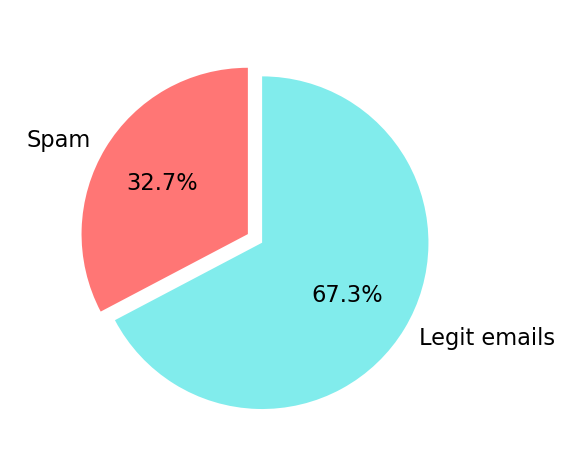

In [23]:
categoty_names = ['Spam', 'Legit emails']
sizes = [amount_of_spam, amount_of_ham]
costume_colors = ['#ff7675', '#81ecec']
plt.figure(figsize=(2, 2), dpi=270)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize':6}, startangle=90,
       autopct='%1.1f%%', colors=costume_colors, explode=[0, 0.1])
plt.show()

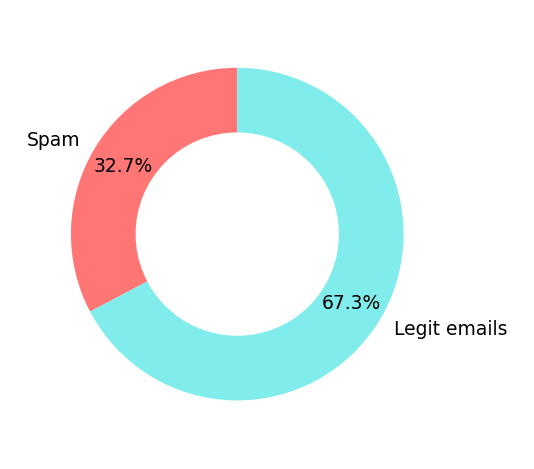

In [24]:
categoty_names = ['Spam', 'Legit emails']
sizes = [amount_of_spam, amount_of_ham]
costume_colors = ['#ff7675', '#81ecec']
plt.figure(figsize=(2, 2), dpi=270)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize':5}, startangle=90,
       autopct='%1.1f%%', colors=costume_colors, pctdistance=0.8)
centre_circle = plt.Circle((0, 0), radius=0.6, color='white')
plt.gca().add_artist(centre_circle)
plt.show()

In [25]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Eid
[nltk_data]     josef\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

In [27]:

nltk.download('stopwords')
nltk.download('shakespeare')
nltk.download('gutenberg')

[nltk_data] Downloading package stopwords to C:\Users\Eid
[nltk_data]     josef\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package shakespeare to C:\Users\Eid
[nltk_data]     josef\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!
[nltk_data] Downloading package gutenberg to C:\Users\Eid
[nltk_data]     josef\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [28]:
stopwords = set(stopwords.words('english'))

In [29]:
if 'hello' in stopwords:
    print('found it')
else:
    print('Nope. not in here.')

Nope. not in here.


In [30]:
msg = 'All work and no play makes Jack a dull boy. to be or not to be.'
words = word_tokenize(msg.lower())
filtered_words = []
for word in words:
    if word not in stopwords:
        filtered_words.append(word)
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

In [31]:
'boy'.isalpha()

True

In [32]:
msg = 'All work and no play makes Jack a dull boy. to be or not to be. \
Nobody expects the Spanish Inquisition'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stopwords and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 'nobodi',
 'expect',
 'spanish',
 'inquisit']

In [33]:
soup = BeautifulSoup(data.at[250, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<html>
 <head>
  <meta content='3D"en-us"' http-equiv='3D"Content-Language"'/>
  <meta 4.0"="" content='3D"Microsoft' frontpage="" name='3D"GENERATOR"'/>
  <meta content='3D"FrontPage.Editor.Document"' name='3D"ProgId"'/>
  <meta 1252"="" charset="utf-8" content='3D"text/html;' http-equiv='3D"Content-Type"'/>
  <title>
   Norton AD
  </title>
 </head>
 <body>
  <table bgcolor='3D"#FFFFFF"' border='3D"0"' height='3D"54"' width='3D"489"'>
   <tr>
    <td align='3D"center"' bgcolor='3D"#FFFFFF"' height='3D"48"' width='3D"100%"'>
     =
     <font color='3D"#CC0000"' face='3D"Impact"' size='3D"3"'>
      Take

      Control of Your Computer With This Top-of-the-Line Software!
     </font>
     &lt;=

/td&gt;
    </td>
   </tr>
  </table>
  <table bgco='lor=3D"#990033"' border='3D"5"' bordercolor='3D"#FFFFFF"' bordercolordark='3D"#000000"' bordercolorlight='3D"#FFFF99"=' cellpadding='3D"3"' cellspacing='3D"3"' collaps='e"' height='3D"567"' style='3D"border-collapse:' width='3D"489"'>
   <tr

In [34]:
soup.get_text()

"\n\n\n\n\n\nNorton AD\n\n\n\n\n=\n\nTake\n\n      Control of Your Computer With This Top-of-the-Line Software!<=\n\n/td>\n\n  \n\n\n\n\n\n\nNorton\n\n            SystemWorks 2002  Software Suite\n\n            -Professional Edition-\n\n\n\n\nIncludes\n\n            Six - Yes 6! \n\n            - Feature-Packed UtilitiesALL for 1\n\n            Special LOW\n\n            Price of Only\n\n            $29.99!\n\n\n\n\n=\n\nThis\n\n            Software Will:\xa0=\n\n-\n\n            Protect your computer from unwanted and  hazardous  vir=\n\nuses\xa0-\n\n            Help secure your private & valuable information\xa0-=\n\n Allow\n\n            you to transfer files and send e-mails  safely\xa0=\n\n;-\n\n            Backup your ALL your data quick and easily\xa0- Improve =\n\nyour\n\n            PC's performance w/superior\n\n            integral diagnostics!\xa0- You'll NEVER have to take =\n\nyour\n\n            PC to the repair shop AGAIN!\n\n\xa0\n\n      \n\n\n6\n\n            Feature

In [35]:

import nltk
from nltk.corpus import stopwords
 
def clean_message(message, stemmer = PorterStemmer(), stopwords=set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    filtered_words = []
    for word in words:
        if word not in stopwords and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
    return filtered_words

In [36]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [37]:
def clean_msg_no_html(message, stemmer = PorterStemmer(), stopwords=set(stopwords.words('english'))):
    soup = BeautifulSoup(message, 'html.parser')
    
    words = word_tokenize(soup.get_text().lower())
    filtered_words = []
    for word in words:
        if word not in stopwords and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
    return filtered_words

In [38]:
clean_msg_no_html(data.at[250, 'MESSAGE'])

['norton',
 'ad',
 'take',
 'control',
 'comput',
 'softwar',
 'norton',
 'systemwork',
 'softwar',
 'suit',
 'includ',
 'six',
 'ye',
 'utilitiesal',
 'special',
 'low',
 'price',
 'softwar',
 'protect',
 'comput',
 'unwant',
 'hazard',
 'use',
 'help',
 'secur',
 'privat',
 'valuabl',
 'inform',
 'allow',
 'transfer',
 'file',
 'send',
 'safe',
 'backup',
 'data',
 'quick',
 'easili',
 'improv',
 'pc',
 'perform',
 'integr',
 'diagnost',
 'never',
 'take',
 'pc',
 'repair',
 'shop',
 'util',
 'great',
 'price',
 'combin',
 'retail',
 'valu',
 'price',
 'includ',
 'free',
 'ship',
 'limit',
 'time',
 'buy',
 'product',
 'get',
 'free',
 'fall',
 'prey',
 'destruct',
 'virus',
 'hacker',
 'protect',
 'valuabl',
 'inform',
 'click',
 'order',
 'call',
 'email',
 'address',
 'obtain',
 'list',
 'uefa',
 'unit',
 'email',
 'feder',
 'spam',
 'approv',
 'list',
 'purchas',
 'code',
 'wish',
 'unsubscrib',
 'list',
 'leas',
 'click',
 'previous',
 'unsubscrib',
 'still',
 'ng',
 'messag',
 

In [39]:
data.iat[5, 0]
data.iloc[5:11]
data.MESSAGE.iloc[5:11]

DOC_ID
5     A POWERHOUSE GIFTING PROGRAM You Don't Want To...
6     Help wanted.  We are a 14 year old fortune 500...
7     <html>\n\n<head>\n\n<title>ReliaQuote - Save U...
8     TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...
9     Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...
10    Cellular Phone Accessories All At Below Wholes...
Name: MESSAGE, dtype: object

In [40]:



first_emails = data.MESSAGE.iloc[0:3].apply(clean_message)
nested_list = [item for sublist in first_emails for item in sublist]
nested_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [41]:
%%time
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\Eid josef\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Eid josef\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: total: 34.8 s
Wall time: 35.1 s


In [42]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [43]:
doc_id_spam = data[data.CATEGORY== 1].index
doc_id_ham = data[data.CATEGORY== 0].index
doc_id_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [44]:
nested_list_spam = nested_list.loc[doc_id_spam]
nested_list_ham = nested_list.loc[doc_id_ham]
list_word_spam = [word for sublist in nested_list_spam for word in sublist]
list_word_ham = [word for sublist in nested_list_ham for word in sublist]

ham_words = pd.Series(list_word_ham).value_counts()
ham_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

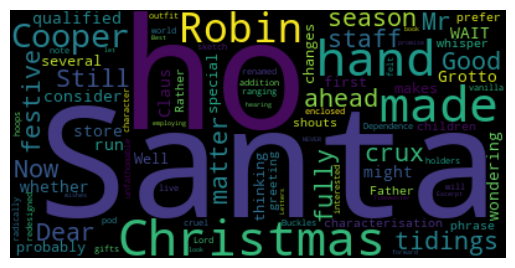

In [45]:
wordcloud = WordCloud().generate(email_body)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [46]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

example_corpus
                                             

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [47]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ''.join(word_list)
novel_as_string

'[MobyDickbyHermanMelville1851]ETYMOLOGY.(SuppliedbyaLateConsumptiveUshertoaGrammarSchool)ThepaleUsher--threadbareincoat,heart,body,andbrain;Iseehimnow.Hewaseverdustinghisoldlexiconsandgrammars,withaqueerhandkerchief,mockinglyembellishedwithallthegayflagsofalltheknownnationsoftheworld.Helovedtodusthisoldgrammars;itsomehowmildlyremindedhimofhismortality."Whileyoutakeinhandtoschoolothers,andtoteachthembywhatnameawhale-fishistobecalledinourtongueleavingout,throughignorance,theletterH,whichalmostalonemakeththesignificationoftheword,youdeliverthatwhichisnottrue."--HACKLUYT"WHALE....Sw.andDan.HVAL.Thisanimalisnamedfromroundnessorrolling;forinDan.HVALTisarchedorvaulted."--WEBSTER\'SDICTIONARY"WHALE....ItismoreimmediatelyfromtheDut.andGer.WALLEN;A.S.WALW-IAN,toroll,towallow."--RICHARDSON\'SDICTIONARYKETOS,GREEK.CETUS,LATIN.WHOEL,ANGLO-SAXON.HVALT,DANISH.WAL,DUTCH.HWAL,SWEDISH.WHALE,ICELANDIC.WHALE,ENGLISH.BALEINE,FRENCH.BALLENA,SPANISH.PEKEE-NUEE-NUEE,FEGEE.PEKEE-NUEE-NUEE,ERROMANGOAN.EXTRACTS

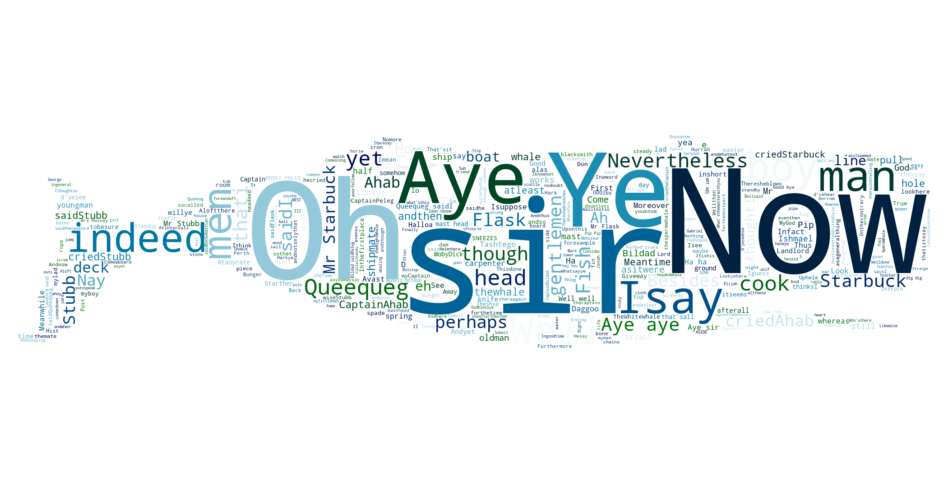

In [48]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

plt.figure(figsize=(18, 6))
wordcloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='ocean').generate(novel_as_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

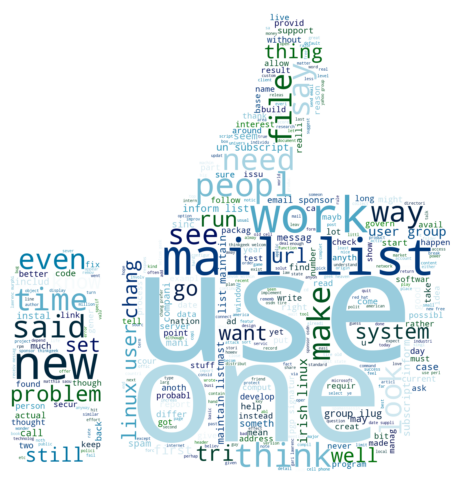

In [49]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

ham_string = ' '.join(list_word_ham)
plt.figure(figsize=(18, 6))
wordcloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='ocean').generate(ham_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

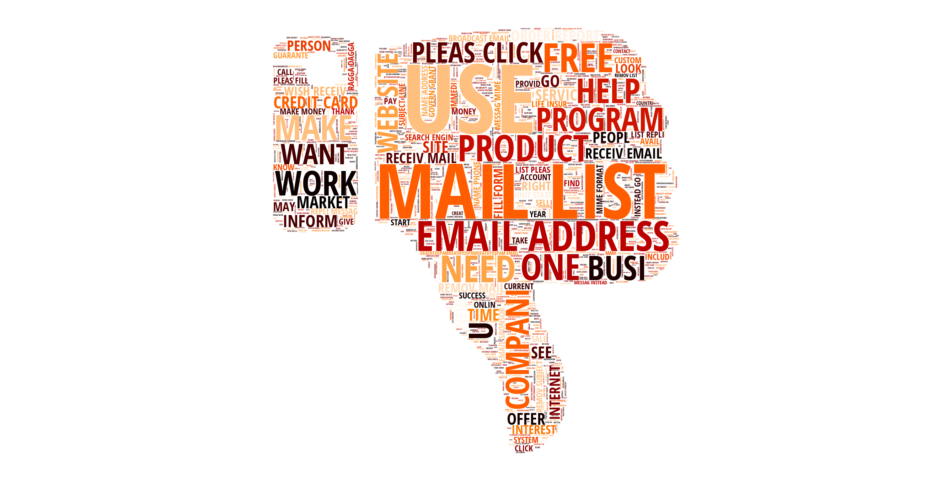

In [50]:

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

spam_string = ' '.join(list_word_spam)
plt.figure(figsize=(18, 6))
wordcloud = WordCloud(font_path=FONT, mask=rgb_array, background_color='white', max_words=2000, colormap='gist_heat').generate(spam_string.upper())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [51]:
list_word = [word for sublist in nested_list for word in sublist]
words = pd.Series(list_word).value_counts()
most_frequent = words[:VOCAB_SIZE]
vocab = pd.DataFrame({'VOCABULARY': most_frequent.index.values})
vocab.index.name = 'WORD_ID'
vocab

,VOCABULARY
WORD_ID,
0,http
1,use
2,list
3,email
4,get
...,...
2495,till
2496,corn
2497,analog


In [52]:
vocab.to_csv(WORD_ID_FILE, index_label= vocab.index.name, header=vocab.VOCABULARY.name)

In [53]:
list_words = ['machine', 'learning', 'fun', 'learn', 'data', 'science', 'app', 'brewery']
for vocab in vocab.VOCABULARY:
    for word in list_words:
        if word == vocab:
            print(word, 'True')

data True
learn True
fun True
app True


In [54]:
len_lists = [len(sublist) for sublist in nested_list]

# data['LEN'] = len_lists
# print('length',data.LEN.max())
# print('Index',data.LEN.idxmax())
# print('EMAIL',data.loc[5775].MESSAGE)
# print('STEMMED',nested_list[5775])
np.argmax(len_lists)
nested_list[np.argmax(len_lists)]
data.at[np.argmax(len_lists), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

In [55]:
features = pd.DataFrame.from_records(nested_list.to_list())
target = data.CATEGORY

In [56]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [57]:
X_train.index.name = X_test.index.name = 'DOC_ID'
y_train

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
       ..
3772    0
5191    0
5226    0
5390    0
860     1
Name: CATEGORY, Length: 4057, dtype: int64

In [58]:
word_index = pd.Index(vocab.VOCABULARY)
word_index.get_loc('thu')

AttributeError: 'str' object has no attribute 'VOCABULARY'

In [ ]:
def make_sparse_matrix(df, indexed_words, labels):
    
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'DOC_ID' : doc_id,'WORD_ID' : word_id, 'LABEL' : category, 'OCCURENCE' : 1}
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [ ]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [ ]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [ ]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped = train_grouped.reset_index()
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')
train_grouped

In [ ]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped = test_grouped.reset_index()
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [ ]:
sparse_train_df.head()

In [ ]:
test_grouped.DOC_ID.unique().shape[0]

In [ ]:
X_test.index.unique().shape[0]

In [ ]:
excluded_emails = []
for i in X_test.index.unique():
    if i not in test_grouped.DOC_ID.unique():
        excluded_emails.append(i)
excluded_emails

In [ ]:
len(excluded_emails)

In [ ]:
data.MESSAGE[1544]